In [2]:
setwd("/projects/CARDIPS/analysis/epigenome_resource")
source("analyses/jennifer/notebooks/functions.R")

set.seed(5366)

# Assign QTLs to independent GWAS locus

## 0. Read GWAS manifest table

In [4]:
manifest = fread("analyses/jennifer/gwas_independent/subset_manifest.txt", data.table = F)  %>% 
    filter(full_trait_id != "continuous-20022-both_sexes-irnt.meta" & full_trait_id != "healthspan_summary")


## 1. Check files

In [5]:
# for (trait in manifest$full_trait_id)
# {
#     file = paste("analyses/jennifer/gwas_independent/indep", paste(trait, "hg38_5e-08.txt", sep = "."), sep = "/")
#     if (file.exists(file) == F)
#     {
#         data = fread(manifest[manifest$full_trait_id == trait,]$filename, data.table = F) %>% mutate(p = as.double(p)) %>% filter(p <= 5e-08)
#         fwrite(data, file, row.names = F, sep = "\t", col.names = F)
#         message(paste(file, "written"), appendLF = F)
#     }
# }

## Identify GWAS independent loci for each trait

### 2.1. Filter for variants that passed genome-wide significance (p < 5e-08) (already done)

In [5]:
for (row in c(1:nrow(manifest)))
{
    outfile = paste("analyses/jennifer/gwas_independent/indep", paste(manifest[row,]$full_trait_id, "hg38_5e-08", "txt", sep = "."), sep = "/")
    if (file.exists(outfile) == F)
    {
        message(manifest[row,]$full_trait_id, appendLF = F)
        data = fread(manifest[row,]$filename, data.table = F) %>% filter(p <= 5e-08)
        fwrite(data, outfile, row.names = F, sep = "\t", col.names = F)
        message(paste("Saved:", outfile), appendLF = F)
    }
}

### 2.2 prune variants (already done)

In [ ]:
cmd = "qsub /projects/CARDIPS/analysis/epigenome_resource/analyses/jennifer/notebooks/11.01.indep_gwas_prune.variant_ct.sh 500 50 0.01"
message(cmd)
system(cmd)

cmd = "qsub /projects/CARDIPS/analysis/epigenome_resource/analyses/jennifer/notebooks/11.01.indep_gwas_prune.variant_ct.sh 500 50 0.1"
message(cmd)
system(cmd)

### 2.3 How many GWAS indep loci per trait (using variant count as window)

In [120]:
kb = 500
r2 = 0.1
wind = 50
type = "ct"

indep = as.data.frame(rbindlist(lapply(manifest$full_trait_id, function(trait)
{
#     message(trait)
    as.data.frame(rbindlist(lapply(c(1:22), function(i)
    {
        if (type == "ct")
        {
            file = paste(getwd(), "analyses/jennifer/gwas_independent/indep", 
                         paste(trait, "hg38_5e-08", sep = "."), 
                         paste(paste0("chr", i), paste(paste0(kb, "ct"), paste0(wind, "wind"), paste0("r", r2), sep = "_"), "prune.in", sep = "."), sep = "/")
        } else
        {
            file = paste(getwd(), "analyses/jennifer/gwas_independent/indep", 
                         paste(trait, "hg38_5e-08", sep = "."), 
                         paste(paste0("chr", i), paste(paste0(kb, "kb"),  paste0("r", r2), sep = "_"), "prune.in", sep = "."), sep = "/")
        }
            
        if (file.exists(file))
        {
            # 1. Get pruned variants
            snps = readLines(file)
            
            # 2. Remove MHC regions
            if (i == 6)
            {
                tmp = data.frame(snp = snps) %>% mutate(pos = unlist(lapply(snp, function(x) { as.numeric(unlist(strsplit(x, "_"))[2]) })))
                tmp = tmp %>% filter(pos <= 28510120 | pos >= 33480577)
                snps = tmp$snp
            }
            data.frame(description = manifest[manifest$full_trait_id == trait,]$description, full_trait_id = trait, chr = i, nloci = length(unique(snps)))
        } else
        {
            # 3. Sometimes, pruning doesn't work if there is only one variant that is genome-wide significant
            file = paste(getwd(), "analyses/jennifer/gwas_independent/indep", 
                     paste(trait, "hg38_5e-08", sep = "."), 
                     paste(paste0("chr", i), "snps", sep = "."), sep = "/")

            snps = data.frame(snp = readLines(file)) %>%
                mutate(chrom = unlist(lapply(snp, function(x) { unlist(strsplit(x, "_"))[1] }))) %>%
                filter(chrom %in% c(1:22))

            snps$chrom = as.numeric(snps$chrom)
            snps = snps %>% filter(!is.na(chrom))
            snps = snps %>% filter(chrom == i)

            # 4. Output GWAS Index for each locus/signal
            if (nrow(snps) > 0)
            {
                snps = snps$snp
                data.frame(description = manifest[manifest$full_trait_id == trait,]$description, full_trait_id = trait, chr = i, nloci = length(unique(snps))) 
            }
        }
    })))
}))) %>% group_by(full_trait_id) %>% dplyr::summarise(total = sum(nloci))

b = merge(indep, manifest[,c("full_trait_id", "description")], by = "full_trait_id") %>% select(description, full_trait_id, total)
b 

message(paste("Total GWAS Loci/Signals:", sum(b$total)))


description,full_trait_id,total
<chr>,<chr>,<int>
HDL cholesterol,biomarkers-30760-both_sexes-irnt.meta,2151
LDL direct,biomarkers-30780-both_sexes-irnt.meta,900
birth weight (eur),BW3_EUR_summary_stats,66
childhood obesity (eur),CHILDHOOD_OBESITY.eur,14
Ventricular rate,continuous-12336-both_sexes-irnt.meta,14
QRS duration,continuous-12340-both_sexes-irnt.meta,50
Body mass index (BMI),continuous-23104-both_sexes-irnt.meta,1857
Pulse rate,continuous-4194-both_sexes-irnt.meta,168
type_1_diabetes,GCST90014023_buildGRCh38,224


Total GWAS Loci/Signals: 6371



### visually check that the prune variants capture a single GWAS locus

In [ ]:
data = fread(manifest[manifest$full_trait_id %like% "timmers",]$filename, data.table = F)

In [9]:
data2 = data[data$chr == "chr6",]

In [10]:
data2$p = as.double(data2$p)

In [11]:
pruned = readLines("analyses/jennifer/gwas_independent/indep/timmers2020_healthspan_lifespan_longevity.hg38_5e-08/chr6.500ct_50wind_r0.01.prune.in")
pruned = as.numeric(unlist(lapply(pruned, function(x) { unlist(strsplit(x, "_"))[2] })))
pruned

[1]    396321  32618190 108687991 160361630 160646860 160883040

In [12]:
head(data2,2)

,chr,pos,a1,a2,af,beta,se,p,n,maf,chrpos
,<chr>,<int>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<chr>
5646060,chr6,202452,T,C,0.063,-0.010112,0.003455,0.00342096,709709,0.063,chr6_202452
5646061,chr6,202777,T,C,0.049,0.000135,0.003888,0.97221600,709709,0.049,chr6_202777


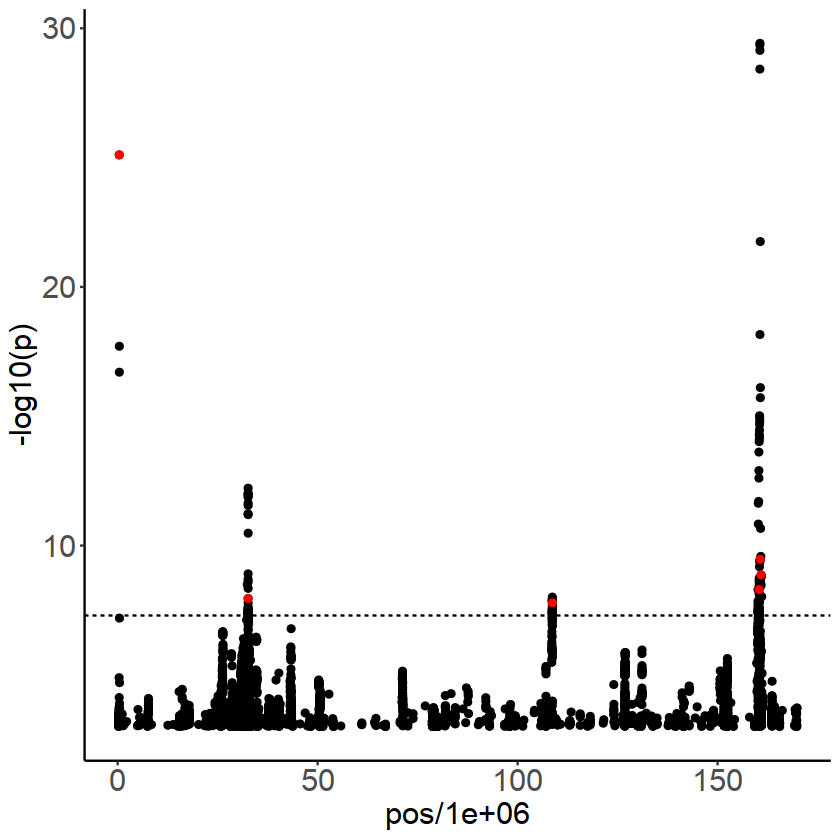

In [13]:
ggplot(data2 %>% filter(p < 1e-3), aes(x = pos/1e6,  y = -log10(p))) + geom_point() + jn_classic + 
    geom_point(data = data2 %>% filter(pos %in% pruned), color = "red") + 
#     geom_vline(xintercept = 28510120/1e6, color = "red") + 
#     geom_vline(xintercept = 36.5, color = "red") + 
#     xlim(28, 37) + 
    geom_hline(yintercept = -log10(5e-08), linetype = "dashed")

# 3. How many GWAS loci explained by eQTLs?

### 3.1 Prepare input for tags

In [45]:
kb = 500
r2 = 0.01
wind = 50
type = "ct"

pruned = as.data.frame(rbindlist(lapply(manifest$full_trait_id, function(trait)
{
#     message(trait)
    as.data.frame(rbindlist(lapply(c(1:22), function(i)
    {
        if (type == "ct")
        {
            file = paste(getwd(), "analyses/jennifer/gwas_independent/indep", 
                         paste(trait, "hg38_5e-08", sep = "."), 
                         paste(paste0("chr", i), paste(paste0(kb, "ct"), paste0(wind, "wind"), paste0("r", r2), sep = "_"), "prune.in", sep = "."), sep = "/")
        } else
        {
            file = paste(getwd(), "analyses/jennifer/gwas_independent/indep", 
                         paste(trait, "hg38_5e-08", sep = "."), 
                         paste(paste0("chr", i), paste(paste0(kb, "kb"),  paste0("r", r2), sep = "_"), "prune.in", sep = "."), sep = "/")
        }
            
        if (file.exists(file))
        {
            # 1. Get pruned variants
            snps = readLines(file)
            
            # 2. Remove MHC regions
            if (i == 6)
            {
                tmp = data.frame(snp = snps) %>% mutate(pos = unlist(lapply(snp, function(x) { as.numeric(unlist(strsplit(x, "_"))[2]) })))
                tmp = tmp %>% filter(pos <= 28510120 | pos >= 33480577)
                snps = tmp$snp
            }
            data.frame(description = manifest[manifest$full_trait_id == trait,]$description, full_trait_id = trait, chr = i, snp = snps)
        } 
    })))
}))) 

In [48]:
pruned %>% head(2)

,description,full_trait_id,chr,snp
,<chr>,<chr>,<int>,<chr>
1,Longevity,lifegen_phase2_bothpl_alldr_2017_09_18,2,2_630070
2,Longevity,lifegen_phase2_bothpl_alldr_2017_09_18,2,2_26705229


In [112]:
gwas = fread("analyses/jennifer/gwas_coloc/all.gwas_summary.all_downstream_traits.2024_0321.txt", data.table = F)  %>%
    filter(full_trait_id %in% manifest$full_trait_id) %>% dplyr::relocate(description, .before = full_trait_id) %>%
    filter(coloc_gwas == T ) 

towrite = gwas %>% select(topsnp)
towrite$topsnp = unlist(lapply(towrite$topsnp, function(x) { paste(unlist(strsplit(x, "_"))[2:3], collapse = "_") }))
head(towrite$topsnp,2)
writeLines(unique(c(towrite$topsnp, pruned$snp)), "analyses/jennifer/gwas_independent/tag_qtl/gwas_topsnp.txt", sep = "\n")

[1] "17_42620270" "11_61820833"

### 3.2 Run tags

In [ ]:
cmd = "cd analyses/jennifer/gwas_independent; qsub /projects/CARDIPS/analysis/epigenome_resource/analyses/jennifer/notebooks/11.02.tagging_gwas_topsnp.sh 500 50 0.01 ct 0.7 500"
system(cmd)

In [ ]:
cmd = "cd analyses/jennifer/gwas_independent; qsub /projects/CARDIPS/analysis/epigenome_resource/analyses/jennifer/notebooks/11.02.tagging_gwas_topsnp.sh 500 50 0.1 ct 0.7 500"
system(cmd)

In [128]:
# cmd = "qsub /projects/CARDIPS/analysis/epigenome_resource/analyses/jennifer/notebooks/11.02.tagging_gwas_topsnp.sh 500 50 0.1 ct 0.1 1000"
# system(cmd)

# cmd = "qsub /projects/CARDIPS/analysis/epigenome_resource/analyses/jennifer/notebooks/11.02.tagging_gwas_topsnp.sh 500 50 0.01 ct 0.2 500"
# system(cmd)

# cmd = "qsub /projects/CARDIPS/analysis/epigenome_resource/analyses/jennifer/notebooks/11.02.tagging_gwas_topsnp.sh 100 1 0.1 ct 0.1 500"
# system(cmd)


### 3.3 Analyze

### 3.3.1 Get GWAS-colocalized QTLs

In [114]:
gwas = fread("analyses/jennifer/gwas_coloc/all.gwas_summary.all_downstream_traits.2024_0321.txt", data.table = F)  %>% filter(coloc_gwas == T & PP.H4.abf >= 0.8 & p.gwas <= 5e-08 & p.eqtl <= 5e-05)
gwas_nodup = gwas  %>% mutate(id = paste(cluster_id, full_trait_id)) %>% group_by(id) %>% dplyr::filter(topsnp_pp == max(topsnp_pp)) # Assign one QTL-GWAS entry

gwas_nodup %>% filter(duplicated(id))

gwas_nodup = gwas_nodup %>% filter(duplicated(id) == F)

gwas_nodup %>% filter(duplicated(id))

Warning message in cbind(parts$left, chars$ellip_h, parts$right, deparse.level = 0L):
“number of rows of result is not a multiple of vector length (arg 2)”
Warning message in cbind(parts$left, chars$ellip_h, parts$right, deparse.level = 0L):
“number of rows of result is not a multiple of vector length (arg 2)”
Warning message in cbind(parts$left, chars$ellip_h, parts$right, deparse.level = 0L):
“number of rows of result is not a multiple of vector length (arg 2)”
Warning message in cbind(parts$left, chars$ellip_h, parts$right, deparse.level = 0L):
“number of rows of result is not a multiple of vector length (arg 2)”


full_trait_id,cluster_id,element_cond,tissue,element_id,element_chr,element_start,element_end,element_name,element_strand,⋯,qtl_type,qtl_combo,module,n_qtltypes,number_elements_coloc,prop_cluster_coloc,coloc_gwas,fetal_unique,has_tfbs,id
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<int>,<int>,<dbl>,<lgl>,<lgl>,<lgl>,<chr>


Warning message in cbind(parts$left, chars$ellip_h, parts$right, deparse.level = 0L):
“number of rows of result is not a multiple of vector length (arg 2)”
Warning message in cbind(parts$left, chars$ellip_h, parts$right, deparse.level = 0L):
“number of rows of result is not a multiple of vector length (arg 2)”
Warning message in cbind(parts$left, chars$ellip_h, parts$right, deparse.level = 0L):
“number of rows of result is not a multiple of vector length (arg 2)”
Warning message in cbind(parts$left, chars$ellip_h, parts$right, deparse.level = 0L):
“number of rows of result is not a multiple of vector length (arg 2)”


full_trait_id,cluster_id,element_cond,tissue,element_id,element_chr,element_start,element_end,element_name,element_strand,⋯,qtl_type,qtl_combo,module,n_qtltypes,number_elements_coloc,prop_cluster_coloc,coloc_gwas,fetal_unique,has_tfbs,id
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<int>,<int>,<dbl>,<lgl>,<lgl>,<lgl>,<chr>


### 3.3.2 Annotate each GWAS locus

In [129]:
kb = 500
wind = 50
r2 = 0.1
type = "ct"

In [130]:
indep = as.data.frame(rbindlist(lapply(manifest$full_trait_id, function(trait)
{
    as.data.frame(rbindlist(lapply(c(1:22), function(i)
    {
        file = paste(getwd(), "analyses/jennifer/gwas_independent/indep", 
                     paste(trait, "hg38_5e-08", sep = "."), 
                     paste(paste0("chr", i), paste(paste0(kb, "ct"), paste0(wind, "wind"), paste0("r", r2), sep = "_"), "prune.in", sep = "."), sep = "/")
        if (file.exists(file))
        {
            # 1. Get GWAS independent loci (i.e., pruned variants)
            snps = readLines(file)
            if (i == 6)
            {
                # 2. Remove loci in MHC regions
                tmp = data.frame(snp = snps) %>% filter(!snp %like% "X") %>% mutate(pos = unlist(lapply(snp, function(x) { as.numeric(unlist(strsplit(x, "_"))[2]) })))
                tmp = tmp %>% filter(pos <= 28510120 | pos >= 33480577)
                snps = tmp$snp
            }
            
            #2. Output GWAS Index for each locus/signal
            data.frame(description = manifest[manifest$full_trait_id == trait,]$description, full_trait_id = trait, chr = i, gwas_index = snps) 
        } else
        {  
            # 3. Sometimes, pruning doesn't work if there is only one variant that is genome-wide significant
            file = paste(getwd(), "analyses/jennifer/gwas_independent/indep", 
                     paste(trait, "hg38_5e-08", sep = "."), 
                     paste(paste0("chr", i), "snps", sep = "."), sep = "/")
            
            snps = data.frame(snp = readLines(file)) %>%
                mutate(chrom = unlist(lapply(snp, function(x) { unlist(strsplit(x, "_"))[1] }))) %>%
                filter(chrom %in% c(1:22))

            snps$chrom = as.numeric(snps$chrom)
            snps = snps %>% filter(!is.na(chrom))
            snps = snps %>% filter(chrom == i)
            
            # 4. Output GWAS Index for each locus/signal
            if (nrow(snps) > 0)
            {
                snps = snps$snp
                data.frame(description = manifest[manifest$full_trait_id == trait,]$description, full_trait_id = trait, chr = i, gwas_index = snps) 
            }
        }
    })))
}))) %>% group_by(full_trait_id)  %>% filter(full_trait_id != "continuous-20022-both_sexes-irnt.meta" & description != "Healthspan") %>% distinct()


In [131]:
# Check that number of loci is the same
a = indep %>% group_by(full_trait_id) %>% distinct() %>% dplyr::summarise(total = n())
a = merge(a, manifest[,c("full_trait_id", "description")], by = "full_trait_id")
a %>% arrange(total) 

message(paste("Total GWAS Loci/Signals:", sum(a$total)))

merge(b, a, by = c("full_trait_id", "description"))  %>% filter(total.x != total.y)

full_trait_id,total,description
<chr>,<int>,<chr>
CHILDHOOD_OBESITY.eur,14,childhood obesity (eur)
continuous-12336-both_sexes-irnt.meta,14,Ventricular rate
lifegen_phase2_bothpl_alldr_2017_09_18,25,Longevity
icd10-I21-both_sexes.meta,30,I21 Acute myocardial infarction
timmers2020_healthspan_lifespan_longevity,35,Multivariate Longevity
icd10-I20-both_sexes.meta,45,I20 Angina pectoris
continuous-12340-both_sexes-irnt.meta,50,QRS duration
BW3_EUR_summary_stats,66,birth weight (eur)
icd10-I25-both_sexes.meta,102,I25 Chronic ischaemic heart disease


Total GWAS Loci/Signals: 6371



full_trait_id,description,total.x,total.y
<chr>,<chr>,<int>,<int>


## 3.3.3 Match each GWAS signal with the colocalized QTL cluster

In [132]:
unique(manifest$full_trait_id)

[1] "lifegen_phase2_bothpl_alldr_2017_09_18"   
 [2] "timmers2020_healthspan_lifespan_longevity"
 [3] "biomarkers-30760-both_sexes-irnt.meta"    
 [4] "biomarkers-30780-both_sexes-irnt.meta"    
 [5] "BW3_EUR_summary_stats"                    
 [6] "CHILDHOOD_OBESITY.eur"                    
 [7] "continuous-12336-both_sexes-irnt.meta"    
 [8] "continuous-12340-both_sexes-irnt.meta"    
 [9] "continuous-23104-both_sexes-irnt.meta"    
[10] "continuous-4194-both_sexes-irnt.meta"     
[11] "GCST90014023_buildGRCh38"                 
[12] "icd10-I20-both_sexes.meta"                
[13] "icd10-I21-both_sexes.meta"                
[14] "icd10-I25-both_sexes.meta"                
[15] "icd10-I48-both_sexes.meta"                
[16] "MAGIC1000G_FG_EUR"                        
[17] "Mahajan.NatGenet2018b.T2D.European_sorted"

In [134]:
indep2 = as.data.frame(rbindlist(lapply(c("PPC", "CVPC", "iPSC"), function(tissue)
{
    message(paste0(tissue, "========="), appendLF = F)
#     if (tissue == "PPC" ) { traits = pancreatic_traits }
#     if (tissue == "CVPC") { traits = cardiac_traits    }
#     if (tissue == "iPSC") { traits = ipsc_traits       }  

    # 1. Get coloc results for relevant traits and tissue
    this2 = gwas_nodup %>% 
            filter(cluster_id %like% tissue) %>%
            mutate(cluster_gwas = paste(cluster_id, full_trait_id)) %>% 
            group_by(cluster_gwas) %>%
            filter(topsnp_pp == max(topsnp_pp)) %>% ungroup() 
    
    print(nrow(this2))
    
    if (nrow(this2) != 0)
    {
        as.data.frame(rbindlist(lapply(unique(manifest$description), function(trait)
        {
            message(trait, appendLF = F)
            full_trait_id = manifest[manifest$description == trait,]$full_trait_id

            tags = as.data.frame(rbindlist(lapply(c(1:22), function(i)
            {
                # File for tags
                tags_file = paste(getwd(), "analyses/jennifer/gwas_independent/tag_qtl", 
                             paste(full_trait_id, "hg38_5e-08", sep = "."), 
                             paste(paste0("chr", i), paste(paste0(kb, type), paste0(wind, "wind"), paste0("r", r2), sep = "_"), "tags.list", sep = "."), sep = "/")

                # File for GWAS loci
                gwas_loci = paste(getwd(), "analyses/jennifer/gwas_independent/indep", 
                                  paste(full_trait_id, "hg38_5e-08", sep = "."), 
                                  paste(paste0("chr", i), paste(paste0(kb, type), paste0(wind, "wind"), paste0("r", r2), sep = "_"), "prune.in", sep = "."), sep = "/")

                if (file.exists(tags_file) & file.exists(gwas_loci))
                {
                    # Read
                    gwas_loci = readLines(gwas_loci)
                    tags = fread(tags_file, data.table = F) 
                    
                    if (nrow(tags) != 0)
                    {
                        # 2. SNP = GWAS Locus, TAGS = QTLs
                        tags = tags %>% 
                            filter(SNP %in% gwas_loci) %>% 
                            tidyr::separate_rows(TAGS, sep = "[|]") 

                        # 3. If GWAS Locus does not tag a QTL, set tag to itself
                        tags$TAGS = ifelse(tags$TAGS == "NONE", tags$SNP, tags$TAGS)
                    }
                    return(tags)
                } 
#                 else
#                 {
#                     message(paste("Skipping", i, tags_file, file.exists(gwas_loci)), appendLF = F)
#                 }
            })))
            
            # Have GWAS index tag itself (same as above)
            tags = rbind(tags, tags %>% mutate(TAGS = SNP)) %>% select(SNP, TAGS) %>% distinct()

            this3 = this2[this2$description == trait,] %>% 
                select(cluster_id, full_trait_id, description, topsnp, qtl_combo, n_members) %>% 
                distinct() %>% 
                dplyr::rename(TAGS = topsnp)

            this3$TAGS = unlist(lapply(this3$TAGS, function(x) { paste(unlist(strsplit(x, "_"))[2:3], collapse = "_") }))

            if (nrow(this3) > 0)
            {
                # Link QTL to GWAS
                out = merge(tags, this3 , by = c("TAGS"))
                
                # Some might not be in the 1000 Genomes Reference Panel so not tagged
                if (nrow(out) > 0)
                {
                    out$qtl_pos = as.numeric(unlist(lapply(out$TAGS, function(x) { unlist(strsplit(x, "_"))[2] })))
                    out$gwas_pos = as.numeric(unlist(lapply(out$SNP, function(x) { unlist(strsplit(x, "_"))[2] })))
                    out$dist = abs(out$gwas_pos - out$qtl_pos)
                    out = out %>% group_by(cluster_id) %>% filter(dist == min(dist))
                }
                
                # Add other GWAS loci
                out = merge(indep, 
                            out %>% select(TAGS, SNP, description, full_trait_id, cluster_id, qtl_combo, n_members) %>% dplyr::rename(qtl_index = TAGS, gwas_index = SNP), 
                            by = c("gwas_index", "description", "full_trait_id"), all.x = T)

                return(out)
            }
        })))
    }
}))) %>% 
    mutate(locus_id = paste(description, gwas_index), cluster_gwas = paste(cluster_id, full_trait_id)) %>% 
    distinct()  %>% 
    filter(full_trait_id != "continuous-20022-both_sexes-irnt.meta")
    
indep2$gwas_id = paste(indep2$gwas_index, indep2$full_trait_id)

PPC=========


[1] 931


Longevity
Multivariate Longevity
HDL cholesterol
LDL direct
birth weight (eur)
childhood obesity (eur)
Ventricular rate
QRS duration
Body mass index (BMI)
Pulse rate
type_1_diabetes
I20 Angina pectoris
I21 Acute myocardial infarction
I25 Chronic ischaemic heart disease
I48 Atrial fibrillation and flutter
fasting glucose
type 2 diabetes
CVPC=========


[1] 931


Longevity
Multivariate Longevity
HDL cholesterol
LDL direct
birth weight (eur)
childhood obesity (eur)
Ventricular rate
QRS duration
Body mass index (BMI)
Pulse rate
type_1_diabetes
I20 Angina pectoris
I21 Acute myocardial infarction
I25 Chronic ischaemic heart disease
I48 Atrial fibrillation and flutter
fasting glucose
type 2 diabetes
iPSC=========


[1] 931


Longevity
Multivariate Longevity
HDL cholesterol
LDL direct
birth weight (eur)
childhood obesity (eur)
Ventricular rate
QRS duration
Body mass index (BMI)
Pulse rate
type_1_diabetes
I20 Angina pectoris
I21 Acute myocardial infarction
I25 Chronic ischaemic heart disease
I48 Atrial fibrillation and flutter
fasting glucose
type 2 diabetes


In [135]:
indep2 %>% filter(duplicated(cluster_gwas) == T & !is.na(cluster_id))

gwas_index,description,full_trait_id,chr,qtl_index,cluster_id,qtl_combo,n_members,locus_id,cluster_gwas,gwas_id
<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>


In [136]:
indep$gwas_id = paste(indep$gwas_index, indep$full_trait_id)

In [137]:
indep %>% filter(!gwas_id %in% indep2$gwas_id)

description,full_trait_id,chr,gwas_index,gwas_id
<chr>,<chr>,<int>,<chr>,<chr>


### Is each cluster assigned to a single locus?

In [138]:
indep2 %>% filter(!is.na(cluster_id)) %>% select(gwas_index, cluster_gwas, description) %>% distinct() %>%
    filter(duplicated(cluster_gwas) == T)

gwas_index,cluster_gwas,description
<chr>,<chr>,<chr>


In [139]:
# gwas_nodup %>% filter(cluster_id == "PPC_661") %>% select(cluster_id, description, full_trait_id, topsnp) %>% distinct()

In [140]:
# indep2 %>% filter(cluster_gwas == "PPC_661 biomarkers-30780-both_sexes-irnt.meta")

### Check all independent GWAS loci are in the table and not lost

In [141]:
a = indep2 %>% select(full_trait_id, gwas_index) %>% distinct()
a = data.frame(table(a$full_trait))

a %>% arrange(Freq)

sum(a$Freq)

Var1,Freq
<fct>,<int>
CHILDHOOD_OBESITY.eur,14
continuous-12336-both_sexes-irnt.meta,14
lifegen_phase2_bothpl_alldr_2017_09_18,25
icd10-I21-both_sexes.meta,30
timmers2020_healthspan_lifespan_longevity,35
icd10-I20-both_sexes.meta,45
continuous-12340-both_sexes-irnt.meta,50
BW3_EUR_summary_stats,66
icd10-I25-both_sexes.meta,102


[1] 6371

### Are all clusters assigned to a locus? If not, assign them to the nearest GWAS signal.

    - This occurs if the lead SNP is not in the 1000 Genomes genotype panel, so can't calculate LD

In [142]:
a = gwas_nodup %>% 
    select(cluster_id, description, full_trait_id, topsnp, qtl_combo, n_members, topsnp_pp) %>% distinct() %>% 
    mutate(cluster_gwas = paste(cluster_id, full_trait_id))

a$paired_with_gwas = ifelse(a$cluster_gwas %in% indep2[!is.na(indep2$cluster_id),]$cluster_gwas, T, F)
a$chrom = unlist(lapply(a$topsnp, function(x) { as.numeric(unlist(strsplit(x, "_"))[2]) }))

table(a$paired_with_gwas)
a = a %>% filter(paired_with_gwas == F) %>% arrange(full_trait_id, chrom) 
a$pos = unlist(lapply(a$topsnp, function(x) { as.numeric(unlist(strsplit(x, "_"))[3]) }))

a = a %>% group_by(cluster_gwas) %>% filter(topsnp_pp == max(topsnp_pp)) 

Adding missing grouping variables: `id`



FALSE  TRUE 
  446   485 

In [143]:
a2 = as.data.frame(rbindlist(lapply(unique(a$full_trait_id), function(x)
{
    message(x, appendLF = F)
    this = indep2 %>% filter(full_trait_id == x)
    this$gwas_pos = as.numeric(unlist(lapply(this$gwas_index, function(x) { unlist(strsplit(x, "_"))[2] })))
    this$gwas_chr = as.numeric(unlist(lapply(this$gwas_index, function(x) { unlist(strsplit(x, "_"))[1] })))
    
    this_a = a %>% filter(full_trait_id == x)
    
    as.data.frame(rbindlist(lapply(c(1:nrow(this_a)), function(row)
    {
        this2 = this %>% filter(gwas_chr == this_a[row,]$chrom)
        this2$dist = abs(this2$gwas_pos - this_a[row,]$pos)
        this2 = this2 %>% filter(dist == min(dist)) %>% distinct() 
        this_a[row,] %>% mutate(gwas_index = unique(this2$gwas_index))
        out = this2 %>% filter(duplicated(gwas_index) == F)
        out$qtl_index = unlist(lapply(this_a[row,]$topsnp, function(x) { paste(unlist(strsplit(x, "_"))[2:3], collapse = "_") }))
        out$cluster_id = this_a[row,]$cluster_id
        out$qtl_combo = this_a[row,]$qtl_combo
        out$n_members = this_a[row,]$n_members
        out$cluster_gwas = paste(out$cluster_id, out$full_trait_id)
        out$gwas_id = paste(out$gwas_index, out$full_trait_id)
        out[,c("dist", "gwas_pos", "gwas_chr")] = NULL
        return(out)
    })))
})))

biomarkers-30760-both_sexes-irnt.meta
biomarkers-30780-both_sexes-irnt.meta
BW3_EUR_summary_stats
CHILDHOOD_OBESITY.eur
continuous-12336-both_sexes-irnt.meta
continuous-12340-both_sexes-irnt.meta
continuous-23104-both_sexes-irnt.meta
continuous-4194-both_sexes-irnt.meta
GCST90014023_buildGRCh38
icd10-I20-both_sexes.meta
icd10-I21-both_sexes.meta
icd10-I25-both_sexes.meta
icd10-I48-both_sexes.meta
lifegen_phase2_bothpl_alldr_2017_09_18
MAGIC1000G_FG_EUR
Mahajan.NatGenet2018b.T2D.European_sorted
timmers2020_healthspan_lifespan_longevity


In [145]:
a2 %>% filter(duplicated(cluster_gwas) == T)

gwas_index,description,full_trait_id,chr,qtl_index,cluster_id,qtl_combo,n_members,locus_id,cluster_gwas,gwas_id
<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>


In [149]:
# Keep signals that were empty but now paired with a QTL
tmp1 = a2

# Keep that already have cluster id
tmp2 = indep2 %>% filter(!is.na(cluster_id))

# keep signals that did not colocalize
tmp3 = indep2 %>% filter(!gwas_id %in% c(tmp1$gwas_id, tmp2$gwas_id))

indep3 = Reduce(rbind, list(tmp1, tmp2, tmp3))

indep3 %>% filter(!is.na(cluster_id)) %>% filter(duplicated(cluster_gwas))

gwas_index,description,full_trait_id,chr,qtl_index,cluster_id,qtl_combo,n_members,locus_id,cluster_gwas,gwas_id
<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>


### Check that all GWAS signals are there again

In [150]:
# Check number of GWAS signals is the same
a = indep3 %>% select(full_trait_id, gwas_index) %>% distinct()
a = data.frame(table(a$full_trait))
a
sum(a$Freq)

Var1,Freq
<fct>,<int>
biomarkers-30760-both_sexes-irnt.meta,2151
biomarkers-30780-both_sexes-irnt.meta,900
BW3_EUR_summary_stats,66
CHILDHOOD_OBESITY.eur,14
continuous-12336-both_sexes-irnt.meta,14
continuous-12340-both_sexes-irnt.meta,50
continuous-23104-both_sexes-irnt.meta,1857
continuous-4194-both_sexes-irnt.meta,168
GCST90014023_buildGRCh38,224


[1] 6371

### Check that no QTLs clusters are missing from the table

In [151]:
a = gwas_nodup %>% 
    select(cluster_id, description, full_trait_id, topsnp, qtl_combo, n_members, topsnp_pp) %>% distinct() %>% 
    mutate(cluster_gwas = paste(cluster_id, full_trait_id))

a$paired_with_gwas = ifelse(a$cluster_gwas %in% indep3[!is.na(indep3$cluster_id),]$cluster_gwas, T, F)
table(a$paired_with_gwas)

Adding missing grouping variables: `id`



TRUE 
 931 

In [152]:
a %>% filter(paired_with_gwas == F)

id,cluster_id,description,full_trait_id,topsnp,qtl_combo,n_members,topsnp_pp,cluster_gwas,paired_with_gwas
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<dbl>,<chr>,<lgl>


### Check if each QTL cluster is assigned to one GWAS locus per trait

In [153]:
indep3 %>% select(gwas_index, description, cluster_id, cluster_gwas) %>% distinct() %>% filter(duplicated(cluster_gwas) == T & !is.na(cluster_id))

gwas_index,description,cluster_id,cluster_gwas
<chr>,<chr>,<chr>,<chr>


## How many GWAS loci colocalized with multiple modules/singletons from the same tissue?

In [154]:
indep3$tissue = unlist(lapply(indep3$cluster_id, function(x) { unlist(strsplit(x, "_"))[1] }))

a = indep3 %>% select(gwas_index, description, cluster_id, tissue) %>% filter(tissue == "PPC") %>% mutate(id = paste(gwas_index, description))
b = data.frame(table(a$id)) %>% dplyr::arrange(desc(Freq)) %>% filter(Freq != 1)

message(paste("# GWAS loci with multiple clusters (PPC):", nrow(b), nrow(data.frame(table(a$id)))))

a = indep3 %>% select(gwas_index, description, cluster_id, tissue) %>% filter(tissue == "CVPC") %>% mutate(id = paste(gwas_index, description))
b = data.frame(table(a$id)) %>% dplyr::arrange(desc(Freq)) %>% filter(Freq != 1)

message(paste("# GWAS loci with multiple clusters (CVPC):", nrow(b), nrow(data.frame(table(a$id)))))

a = indep3 %>% select(gwas_index, description, cluster_id, tissue) %>% filter(tissue == "iPSC") %>% mutate(id = paste(gwas_index, description))
b = data.frame(table(a$id)) %>% dplyr::arrange(desc(Freq)) %>% filter(Freq != 1)

message(paste("# GWAS loci with multiple clusters (iPSC):", nrow(b), nrow(data.frame(table(a$id)))))

# GWAS loci with multiple clusters (PPC): 12 228

# GWAS loci with multiple clusters (CVPC): 39 326

# GWAS loci with multiple clusters (iPSC): 20 299



In [155]:
table(indep3$tissue)


CVPC iPSC  PPC 
 366  319  246 

### check if QTL module/signleton identified the same cand. causal variant for the GWAS locus

This is still confounding because coloc assumes that there is a single causal variant.

In [156]:
tmp = as.data.frame(rbindlist(lapply(c("PPC", "CVPC", "iPSC"), function(tiss)
{
    a = indep3 %>% 
        filter(full_trait_id != "continuous-20022-both_sexes-irnt.meta") %>% 
        select(gwas_index, full_trait_id, description, cluster_id, tissue) %>% 
        filter(tissue == tiss) %>% 
        mutate(id = paste(gwas_index, full_trait_id))
    b = data.frame(table(a$id)) %>% dplyr::arrange(desc(Freq)) %>% filter(Freq != 1)

    c = indep3 %>% 
        filter(full_trait_id != "continuous-20022-both_sexes-irnt.meta") %>% 
        select(gwas_index, full_trait_id, description, cluster_id, tissue) %>% 
        filter(tissue == tiss) %>% 
        mutate(id = paste(gwas_index, full_trait_id)) %>% 
        filter(id %in% b$Var1) %>%
        mutate(cluster_gwas = paste(cluster_id, id)) %>%
        mutate(id = paste(cluster_id, full_trait_id))

    d = gwas_nodup %>% select(cluster_id, full_trait_id, description, topsnp_pp, topsnp) 
    d = merge(d %>% select(id, topsnp, topsnp_pp), c %>% mutate(id = paste(cluster_id, full_trait_id)), by = "id", all.y = T)

    d = d %>% mutate(id = paste(gwas_index, full_trait_id)) %>% arrange(id)

    e = as.data.frame(rbindlist(lapply(unique(d$id), function(x)
    {
        data.frame(id = x, nclusters = length(unique(d[d$id == x,]$cluster_id)), ntopsnps = length(unique(d[d$id == x,]$topsnp)))
    }))) %>%
        mutate(causal = ifelse(nclusters == ntopsnps, "different", "same"))

    return(e %>% mutate(tissue = tiss))
})))

message(paste("# loci:", length(unique(tmp$id))))

table(tmp$causal)
summary(tmp$nclusters)

tmp %>% arrange(id)



Adding missing grouping variables: `id`
Adding missing grouping variables: `id`
Adding missing grouping variables: `id`
# loci: 65




different      same 
       40        31 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  2.000   2.000   2.000   2.099   2.000   4.000 

id,nclusters,ntopsnps,causal,tissue
<chr>,<int>,<int>,<chr>,<chr>
1_16980100 continuous-23104-both_sexes-irnt.meta,2,2,different,CVPC
1_205770138 biomarkers-30760-both_sexes-irnt.meta,2,1,same,CVPC
1_62453356 biomarkers-30760-both_sexes-irnt.meta,2,2,different,CVPC
1_62453356 biomarkers-30780-both_sexes-irnt.meta,2,2,different,PPC
10_103707199 icd10-I48-both_sexes.meta,2,1,same,CVPC
10_63387659 icd10-I48-both_sexes.meta,2,2,different,CVPC
11_119040329 continuous-23104-both_sexes-irnt.meta,2,1,same,CVPC
11_130998688 continuous-23104-both_sexes-irnt.meta,3,2,same,CVPC
11_14673589 biomarkers-30760-both_sexes-irnt.meta,2,1,same,iPSC


In [157]:
tmp %>% filter(causal == "same")

id,nclusters,ntopsnps,causal,tissue
<chr>,<int>,<int>,<chr>,<chr>
11_61819414 biomarkers-30760-both_sexes-irnt.meta,3,1,same,PPC
11_61858251 continuous-4194-both_sexes-irnt.meta,3,1,same,PPC
11_61874070 biomarkers-30780-both_sexes-irnt.meta,4,2,same,PPC
16_29983601 biomarkers-30760-both_sexes-irnt.meta,3,2,same,PPC
7_100879824 continuous-4194-both_sexes-irnt.meta,2,1,same,PPC
7_90173282 MAGIC1000G_FG_EUR,3,1,same,PPC
1_205770138 biomarkers-30760-both_sexes-irnt.meta,2,1,same,CVPC
10_103707199 icd10-I48-both_sexes.meta,2,1,same,CVPC
11_119040329 continuous-23104-both_sexes-irnt.meta,2,1,same,CVPC


## Create a column annotating each GWAS locus with all QTL types that it colocalized with for each tissue type

In [158]:
collapsed = c()

In [159]:
a = indep3 %>% filter(tissue == "PPC") %>%
    mutate(gwas_id = paste(gwas_index, full_trait_id)) %>% 
    group_by(gwas_id) %>%
    dplyr::mutate(qtl_combo2 = paste(qtl_combo, collapse = ","))

table(a$qtl_combo2)

message(paste("# GWAS signals that need to be collapsed:", length(unique(a[a$qtl_combo2 %like% "[,]",]$gwas_id)), length(unique(a$gwas_id))))

collapsed = c(collapsed, a[a$qtl_combo2 %like% "[,]",]$gwas_id)

a$qtl_combo2 = unlist(lapply(a$qtl_combo2, function(x)
{
    phenos = sort(unique(unlist(strsplit(unlist(strsplit(x, "-")), ","))))
    paste(phenos, collapse = "-")
}))

table(a$qtl_combo2)


             ATAC          ATAC-RNA ATAC-RNA,ATAC-RNA  ATAC-RNA,RNA,RNA 
              105                40                 4                 3 
        ATAC,ATAC     ATAC,ATAC,RNA          ATAC,RNA               RNA 
                4                 3                 2                71 
     RNA,ATAC-RNA           RNA,RNA       RNA,RNA,RNA  RNA,RNA,RNA,ATAC 
                2                 2                 6                 4 

# GWAS signals that need to be collapsed: 12 228




    ATAC ATAC-RNA      RNA 
     109       58       79 

In [160]:
a2 = indep3 %>% filter(tissue == "CVPC") %>%
    mutate(gwas_id = paste(gwas_index, full_trait_id)) %>% 
    group_by(gwas_id) %>%
    dplyr::mutate(qtl_combo2 = paste(qtl_combo, collapse = ","))

table(a2$qtl_combo2)

message(paste("# GWAS signals that need to be collapsed:", length(unique(a2[a2$qtl_combo2 %like% "[,]",]$gwas_id)), length(unique(a2$gwas_id))))

collapsed = c(collapsed, a2[a2$qtl_combo2 %like% "[,]",]$gwas_id)

a2$qtl_combo2 = unlist(lapply(a2$qtl_combo2, function(x)
{
    phenos = sort(unique(unlist(strsplit(unlist(strsplit(x, "-")), ","))))
    paste(phenos, collapse = "-")
}))

table(a2$qtl_combo2)


                        ATAC                    ATAC-ChIP 
                          90                           39 
               ATAC-ChIP-RNA  ATAC-ChIP-RNA,ATAC-ChIP-RNA 
                          31                            2 
              ATAC-ChIP,ATAC          ATAC-ChIP,ATAC-ChIP 
                           4                            2 
ATAC-ChIP,ATAC-ChIP-RNA,ATAC               ATAC-ChIP,ChIP 
                           3                            2 
          ATAC-ChIP,ChIP-RNA                     ATAC-RNA 
                          10                           19 
          ATAC-RNA,ATAC-ChIP                ATAC-RNA,ChIP 
                           2                            6 
                   ATAC,ATAC                    ATAC,ChIP 
                           4                            6 
                        ChIP                     ChIP-RNA 
                          52                           10 
          ChIP-RNA,ATAC-ChIP                ChIP-RNA,Ch

# GWAS signals that need to be collapsed: 39 326




         ATAC     ATAC-ChIP ATAC-ChIP-RNA      ATAC-RNA          ChIP 
           94            65            60            25            52 
     ChIP-RNA           RNA 
           20            50 

In [161]:
a3 = indep3 %>% filter(tissue == "iPSC") %>%
    mutate(gwas_id = paste(gwas_index, full_trait_id)) %>% 
    group_by(gwas_id) %>%
    dplyr::mutate(qtl_combo2 = paste(qtl_combo, collapse = ","))

table(a3$qtl_combo2)

message(paste("# GWAS signals that need to be collapsed:", length(unique(a3[a3$qtl_combo2 %like% "[,]",]$gwas_id)), length(unique(a3$gwas_id))))

collapsed = c(collapsed, a3[a3$qtl_combo2 %like% "[,]",]$gwas_id)

a3$qtl_combo2 = unlist(lapply(a3$qtl_combo2, function(x)
{
    phenos = sort(unique(unlist(strsplit(unlist(strsplit(x, "-")), ","))))
    paste(phenos, collapse = "-")
}))

table(a3$qtl_combo2)


             ATAC     ATAC-ChIP-RNA          ATAC-RNA     ATAC-RNA,ATAC 
               84                 1                64                 2 
ATAC-RNA,ATAC-RNA      ATAC-RNA,RNA         ATAC,ATAC     ATAC,ATAC-RNA 
                4                10                 2                 2 
              RNA          RNA,ATAC      RNA,ATAC-RNA           RNA,RNA 
              130                 6                 4                10 

# GWAS signals that need to be collapsed: 20 299




         ATAC ATAC-ChIP-RNA      ATAC-RNA           RNA 
           86             1            92           140 

In [162]:
message(paste("Signals that need to be collapsed:", length(unique(collapsed))))

setdiff(collapsed, tmp$id)
setdiff(tmp$id, collapsed)

Signals that need to be collapsed: 65



character(0)

character(0)

In [163]:
indep4 =  data.frame(Reduce(rbind, list(a, a2, a3)) %>% dplyr::rename(qtl_combo_collapse = qtl_combo2) %>% ungroup())
indep4 = indep4[rowSums(is.na(indep4)) != ncol(indep4), ] %>% filter(!is.na(gwas_id))

In [164]:
length(unique(indep3$gwas_id))
length(unique(indep4$gwas_id))

[1] 6371

[1] 586

In [167]:
table(indep4$qtl_combo_collapse)


         ATAC     ATAC-ChIP ATAC-ChIP-RNA      ATAC-RNA          ChIP 
          289            65            61           175            52 
     ChIP-RNA           RNA 
           20           269 

# Annotate which is iPSCORE unique

In [177]:
indep4$fetal_unique = ifelse(indep4$cluster_id %in% gwas_nodup[gwas_nodup$fetal_unique == T,]$cluster_id, T, F)

In [179]:
indep4$fetal_unique_gwas = ifelse(indep4$cluster_gwas %in% gwas_nodup[gwas_nodup$fetal_unique == F,]$id, F, T)
table(indep4$fetal_unique_gwas)

indep4$fetal_unique_gwas = ifelse(!indep4$gwas_id %in% indep4[indep4$fetal_unique_gwas == F,]$gwas_id, T, F)
table(indep4$fetal_unique_gwas)

indep4 %>% filter(fetal_unique_gwas == T)


FALSE  TRUE 
  918    13 


FALSE  TRUE 
  919    12 

gwas_index,description,full_trait_id,chr,qtl_index,cluster_id,qtl_combo,n_members,locus_id,cluster_gwas,gwas_id,tissue,qtl_combo_collapse,fetal_unique,fetal_unique_gwas
<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<lgl>,<lgl>
4_54664582,Body mass index (BMI),continuous-23104-both_sexes-irnt.meta,4,4_54631000,PPC_10855,ATAC,1,Body mass index (BMI) 4_54664582,PPC_10855 continuous-23104-both_sexes-irnt.meta,4_54664582 continuous-23104-both_sexes-irnt.meta,PPC,ATAC,TRUE,TRUE
1_217554709,Pulse rate,continuous-4194-both_sexes-irnt.meta,1,1_217548256,PPC_1868,ATAC,1,Pulse rate 1_217554709,PPC_1868 continuous-4194-both_sexes-irnt.meta,1_217554709 continuous-4194-both_sexes-irnt.meta,PPC,ATAC,TRUE,TRUE
12_124385271,HDL cholesterol,biomarkers-30760-both_sexes-irnt.meta,12,12_124385271,CVPC_7091,ATAC,1,HDL cholesterol 12_124385271,CVPC_7091 biomarkers-30760-both_sexes-irnt.meta,12_124385271 biomarkers-30760-both_sexes-irnt.meta,CVPC,ATAC,TRUE,TRUE
5_68418419,HDL cholesterol,biomarkers-30760-both_sexes-irnt.meta,5,5_68418419,CVPC_17073,ChIP,1,HDL cholesterol 5_68418419,CVPC_17073 biomarkers-30760-both_sexes-irnt.meta,5_68418419 biomarkers-30760-both_sexes-irnt.meta,CVPC,ChIP,TRUE,TRUE
9_76115850,LDL direct,biomarkers-30780-both_sexes-irnt.meta,9,9_76115850,CVPC_21110,ATAC,1,LDL direct 9_76115850,CVPC_21110 biomarkers-30780-both_sexes-irnt.meta,9_76115850 biomarkers-30780-both_sexes-irnt.meta,CVPC,ATAC,TRUE,TRUE
2_35296679,Body mass index (BMI),continuous-23104-both_sexes-irnt.meta,2,2_35296679,CVPC_1493,ChIP,2,Body mass index (BMI) 2_35296679,CVPC_1493 continuous-23104-both_sexes-irnt.meta,2_35296679 continuous-23104-both_sexes-irnt.meta,CVPC,ChIP,TRUE,TRUE
5_166341030,Body mass index (BMI),continuous-23104-both_sexes-irnt.meta,5,5_166341030,CVPC_17699,ATAC,1,Body mass index (BMI) 5_166341030,CVPC_17699 continuous-23104-both_sexes-irnt.meta,5_166341030 continuous-23104-both_sexes-irnt.meta,CVPC,ATAC,TRUE,TRUE
5_167935411,Body mass index (BMI),continuous-23104-both_sexes-irnt.meta,5,5_167935411,CVPC_17708,ChIP,1,Body mass index (BMI) 5_167935411,CVPC_17708 continuous-23104-both_sexes-irnt.meta,5_167935411 continuous-23104-both_sexes-irnt.meta,CVPC,ChIP,TRUE,TRUE
9_13703276,HDL cholesterol,biomarkers-30760-both_sexes-irnt.meta,9,9_13703276,iPSC_16946,ATAC,1,HDL cholesterol 9_13703276,iPSC_16946 biomarkers-30760-both_sexes-irnt.meta,9_13703276 biomarkers-30760-both_sexes-irnt.meta,iPSC,ATAC,TRUE,TRUE


In [186]:
indep4$tissue = unlist(lapply(indep4$cluster_id, function(x) { unlist(strsplit(x, "_"))[1] }))

In [187]:
table(indep4$tissue)


CVPC iPSC  PPC 
 366  319  246 

In [188]:
indep4 = indep4 %>% filter(full_trait_id != "continuous-20022-both_sexes-irnt.meta" & description != "Healthspan")

In [189]:
length(unique(indep3$gwas_id))
length(unique(indep4$gwas_id))

[1] 6371

[1] 586

In [190]:
table(indep4$description, indep4$tissue)

                                     
                                      CVPC iPSC PPC
  birth weight (eur)                     8   11   3
  Body mass index (BMI)                108   91  60
  childhood obesity (eur)                0    2   2
  fasting glucose                        8    8   9
  HDL cholesterol                      102   75  63
  I20 Angina pectoris                    2    3   3
  I21 Acute myocardial infarction        1    3   3
  I25 Chronic ischaemic heart disease    4   10   3
  I48 Atrial fibrillation and flutter   16    9   5
  LDL direct                            31   33  29
  Longevity                              2    5   3
  Multivariate Longevity                 4    7   3
  Pulse rate                            22   13  15
  QRS duration                           7    0   0
  type 2 diabetes                       36   36  33
  type_1_diabetes                       13   13  12
  Ventricular rate                       2    0   0

In [191]:
fwrite(indep4, "analyses/jennifer/gwas_independent/all_results.qtl_coloc.txt", row.names = F, sep = "\t") # only reports QTL-colocalized GWAS

In [192]:
fwrite(indep3, "analyses/jennifer/gwas_independent/all_results.txt", row.names = F, sep = "\t") # has gwas loci that did not colocalize

In [193]:
table(gwas_nodup$coloc_gwas)
summary(gwas_nodup$p.eqtl)
summary(gwas_nodup$p.gwas)


TRUE 
 931 

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
0.000e+00 0.000e+00 9.680e-09 2.333e-06 8.178e-07 4.864e-05 

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
0.000e+00 0.000e+00 3.548e-11 5.635e-09 3.532e-09 4.977e-08 